# Correlation statistics 
### The information computed here is presented in the _Methods and Materials_ chapter, as well as under the second (_Waveform-based and spike-timing features allow near-perfect classification of PYR and PV cells_) and third (_Transforming multi-channel spike waveforms to event-based delta-like functions removes all waveform-based information and allows extracting purely spatial features_) subsections of the _Results_. It is also presented in the Extended Data Figures 2-1, 2-2, and 3-1.
#### Note that the _p-values_ for each correlation are computed outside of this notebook in Matlab.

In [1]:
from notebooks_constants import SRC_PATH
import sys
sys.path.insert(0, SRC_PATH)

import os
import numpy as np
import pandas as pd
import scipy.stats as stats
import scipy.io as io

import matplotlib.pyplot as plt
import seaborn as sns

from constants import SPATIAL, SPIKE_TIMING, WAVEFORM
from constants import feature_names_org as feature_names
from perm_test import calc_perm_test

from paths import SAVE_PATH

In [2]:
PATH = SAVE_PATH + '0/'

df = None
files = os.listdir(PATH)
for file in sorted(files):
    if df is None:
        df = pd.read_csv(PATH + file)
        if df.label[0] < 0:
            df = None
    else:
        temp = pd.read_csv(PATH + file)
        if temp.label[0] < 0:
            continue
        df = df.append(temp)

df = df[feature_names]

In [3]:
mod_d = {'spatial': SPATIAL[:-1], 'spike-timing': SPIKE_TIMING[:-1], 'waveform': WAVEFORM[:-1],
         'events': [i for i in SPATIAL[:-1] if 'SPD' not in feature_names[i]],
         'modalities': SPATIAL[:-1] + SPIKE_TIMING[:-1] + WAVEFORM[:-1]}

spatial_families = {'value-based': ["SPD_Count", "SPD_SD", "SPD_Area"],
                    'time-based': ["NEG_Time-lag_SS", "NEG_Time-lag_SD", "FMC_Time-lag_SS", 
                                   "FMC_Time-lag_SD", "SMC_Time-lag_SS", "SMC_Time-lag_SD"],
                    'graph-based': ["NEG_Graph_Average_weight", "NEG_Graph_Shortest_path", "NEG_Graph_Longest_path",
                                    "FMC_Graph_Average_weight", "FMC_Graph_Shortest_path", "FMC_Graph_Longest_path",
                                    "SMC_Graph_Average_weight", "SMC_Graph_Shortest_path", "SMC_Graph_Longest_path"]}

st_families = {'short': ['D_KL_short', 'Uniform_distance', 'Rise_time'],
               'long': ['D_KL_long', 'Jump_index'],
               'wide-band': ['Firing_rate', 'PSD_center', "PSD'_center"]}

wf_families = {'WF': ['TTP_duration', 'TTP_magnitude', 'FWHM', 'Rise_coefficient'],
               'first-derivative': ['Max_speed'],
               'second-derivative': ['Break_measure', 'Smile_cry', 'Acceleration']}

event_families = {'FMC': ['FMC_Time-lag_SS', 'FMC_Time-lag_SD', "FMC_Graph_Average_weight",
                          "FMC_Graph_Shortest_path", "FMC_Graph_Longest_path"],
                  'NEG': ['NEG_Time-lag_SS', 'NEG_Time-lag_SD', "NEG_Graph_Average_weight",
                          "NEG_Graph_Shortest_path", "NEG_Graph_Longest_path"],
                  'SMC': ['SMC_Time-lag_SS', 'SMC_Time-lag_SD', "SMC_Graph_Average_weight",
                          "SMC_Graph_Shortest_path", "SMC_Graph_Longest_path"]}

modality_families = {'spatial': [feature_names[i] for i in SPATIAL[:-1]],
                     'spike-timing': [feature_names[i] for i in SPIKE_TIMING[:-1]],
                     'waveform': [feature_names[i] for i in WAVEFORM[:-1]]}

In [4]:
families_d = {'spatial': spatial_families, 'spike-timing': st_families, 'waveform': wf_families,
              'events': event_families, 'modalities': modality_families}

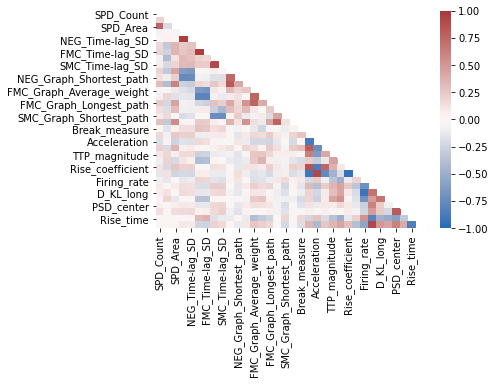

In [5]:
corr_mat = df.corr(method="spearman")
mask = np.triu(np.ones_like(corr_mat, dtype=bool))
plt.yticks(rotation=30)
cmap = sns.color_palette("vlag", as_cmap=True)

_ = sns.heatmap(corr_mat, annot=False, fmt='.2f', mask=mask, vmin=-1, vmax=1, cmap=cmap,
                    annot_kws={"fontsize": 1})

plt.show()

#### Correlations within and across modalities, families and spatial events

In [6]:
for mod in mod_d:
    print(mod)
    
    mod_mat = corr_mat.loc[[feature_names[i] for i in mod_d[mod]], [feature_names[i] for i in mod_d[mod]]].abs()
    mod_np = mod_mat.to_numpy()
    mask = np.triu(np.ones_like(mod_np, dtype=bool))
    mod_np = mod_np[~mask]
    print(f'    median (IQR) correlation: {np.median(mod_np): .3f} ({np.quantile(mod_np, 0.25): .3f}, {np.quantile(mod_np, 0.75): .3f})')
    print()
    
    for fam in families_d[mod]:
        fam_mat = mod_mat.loc[families_d[mod][fam], families_d[mod][fam]].to_numpy()
        mask = np.triu(np.ones_like(fam_mat, dtype=bool))
        fam_mat = fam_mat[~mask].flatten()
        if len(fam_mat) > 0:
            print(f'    median (IQR) correlation of {fam}: {np.median(fam_mat): .3f} ({np.quantile(fam_mat, 0.25): .3f}, {np.quantile(fam_mat, 0.75): .3f})')
        else:
            print(f'    median (IQR) correlation of {fam}: None (None None)')        
    print()
    
    for i, fam1 in enumerate(families_d[mod]):
        for j, fam2 in enumerate(families_d[mod]):
            if i >= j:
                continue
            cross_mat = mod_mat.loc[families_d[mod][fam1], families_d[mod][fam2]].to_numpy().flatten()
            print(f'    median (IQR) correlation of {fam1} X {fam2}: {np.median(cross_mat): .3f} ({np.quantile(cross_mat, 0.25): .3f}, {np.quantile(cross_mat, 0.75): .3f})')    
    print()

spatial
    median (IQR) correlation:  0.203 ( 0.098,  0.332)

    median (IQR) correlation of value-based:  0.208 ( 0.204,  0.490)
    median (IQR) correlation of time-based:  0.285 ( 0.244,  0.332)
    median (IQR) correlation of graph-based:  0.237 ( 0.122,  0.420)

    median (IQR) correlation of value-based X time-based:  0.153 ( 0.054,  0.243)
    median (IQR) correlation of value-based X graph-based:  0.198 ( 0.120,  0.312)
    median (IQR) correlation of time-based X graph-based:  0.171 ( 0.080,  0.278)

spike-timing
    median (IQR) correlation:  0.524 ( 0.378,  0.695)

    median (IQR) correlation of short:  0.850 ( 0.828,  0.879)
    median (IQR) correlation of long:  0.694 ( 0.694,  0.694)
    median (IQR) correlation of wide-band:  0.278 ( 0.257,  0.547)

    median (IQR) correlation of short X long:  0.491 ( 0.466,  0.513)
    median (IQR) correlation of short X wide-band:  0.548 ( 0.480,  0.611)
    median (IQR) correlation of long X wide-band:  0.243 ( 0.235,  0.587)

w

In [7]:
wf_mat = corr_mat.loc[[feature_names[i] for i in mod_d['waveform']],[feature_names[i] for i in mod_d['waveform']]].abs()
wf_np = wf_mat.to_numpy()
mask_wf = np.triu(np.ones_like(wf_np, dtype=bool))
wf_np = wf_np[~mask_wf]

st_mat = corr_mat.loc[[feature_names[i] for i in mod_d['spike-timing']],[feature_names[i] for i in mod_d['spike-timing']]].abs()
st_np = st_mat.to_numpy()
mask_st = np.triu(np.ones_like(st_np, dtype=bool))
st_np = st_np[~mask_st]

spat_mat = corr_mat.loc[[feature_names[i] for i in mod_d['spatial']],[feature_names[i] for i in mod_d['spatial']]].abs()
spat_np = spat_mat.to_numpy()
mask_spat = np.triu(np.ones_like(spat_np, dtype=bool))
spat_np = spat_np[~mask_spat]

print('correlation differences between modalities')
print(f'Spatial vs. Spike-timing p-value={stats.mannwhitneyu(st_np, spat_np)}')
print(f'Spatial vs. Waveform p-value={stats.mannwhitneyu(wf_np, spat_np)}')

correlation differences between modalities
Spatial vs. Spike-timing p-value=MannwhitneyuResult(statistic=822.0, pvalue=1.1301917203452112e-07)
Spatial vs. Waveform p-value=MannwhitneyuResult(statistic=1277.0, pvalue=0.0003475223977366879)


#### Correlations of individual features with the rest

spatial
Median (IQR) correlation of SPD_Count:  0.144 ( 0.082,  0.210)
Median (IQR) correlation of SPD_SD:  0.208 ( 0.166,  0.301)
Median (IQR) correlation of SPD_Area:  0.221 ( 0.129,  0.433)
Median (IQR) correlation of NEG_Time-lag_SS:  0.192 ( 0.066,  0.323)
Median (IQR) correlation of NEG_Time-lag_SD:  0.205 ( 0.087,  0.314)
Median (IQR) correlation of FMC_Time-lag_SS:  0.241 ( 0.178,  0.308)
Median (IQR) correlation of FMC_Time-lag_SD:  0.230 ( 0.150,  0.314)
Median (IQR) correlation of SMC_Time-lag_SS:  0.203 ( 0.114,  0.286)
Median (IQR) correlation of SMC_Time-lag_SD:  0.214 ( 0.112,  0.330)
Median (IQR) correlation of NEG_Graph_Average_weight:  0.314 ( 0.065,  0.433)
Median (IQR) correlation of NEG_Graph_Shortest_path:  0.172 ( 0.135,  0.230)
Median (IQR) correlation of NEG_Graph_Longest_path:  0.293 ( 0.181,  0.418)
Median (IQR) correlation of FMC_Graph_Average_weight:  0.171 ( 0.106,  0.332)
Median (IQR) correlation of FMC_Graph_Shortest_path:  0.134 ( 0.082,  0.195)
Median 

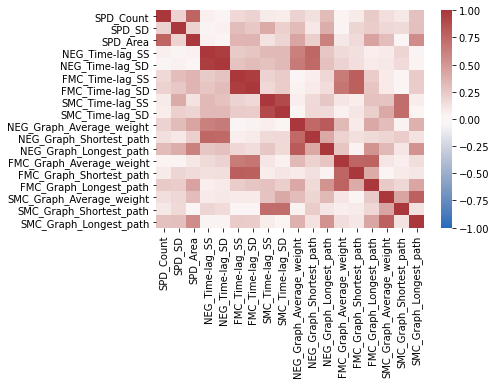

spike-timing
Median (IQR) correlation of Firing_rate:  0.548 ( 0.404,  0.705)
Median (IQR) correlation of D_KL_short:  0.688 ( 0.545,  0.758)
Median (IQR) correlation of D_KL_long:  0.502 ( 0.353,  0.691)
Median (IQR) correlation of Jump_index:  0.480 ( 0.340,  0.605)
Median (IQR) correlation of PSD_center:  0.593 ( 0.260,  0.611)
Median (IQR) correlation of PSD'_center:  0.312 ( 0.240,  0.440)
Median (IQR) correlation of Rise_time:  0.531 ( 0.489,  0.700)
Median (IQR) correlation of Uniform_distance:  0.548 ( 0.475,  0.730)


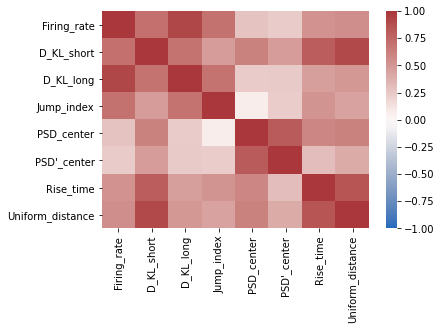

waveform
Median (IQR) correlation of Break_measure:  0.189 ( 0.076,  0.237)
Median (IQR) correlation of FWHM:  0.807 ( 0.446,  0.872)
Median (IQR) correlation of Acceleration:  0.726 ( 0.460,  0.871)
Median (IQR) correlation of Max_speed:  0.726 ( 0.357,  0.758)
Median (IQR) correlation of TTP_magnitude:  0.450 ( 0.387,  0.542)
Median (IQR) correlation of TTP_duration:  0.200 ( 0.158,  0.260)
Median (IQR) correlation of Rise_coefficient:  0.754 ( 0.277,  0.861)
Median (IQR) correlation of Smile_cry:  0.762 ( 0.330,  0.909)


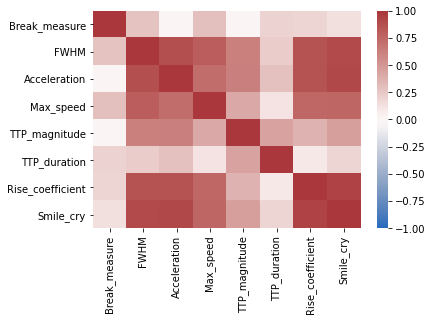

In [8]:
for mod in mod_d:
    if mod in ['events', 'modalities']:
        continue
    print(mod)
    mod_mat = corr_mat.loc[[feature_names[i] for i in mod_d[mod]],[feature_names[i] for i in mod_d[mod]]].abs()
    mod_np = mod_mat.to_numpy()
    
    for i, col in enumerate(mod_mat.columns):
        col_cor = mod_mat[[col]].to_numpy()
        col_cor = np.concatenate((col_cor[:i], col_cor[i + 1:]), axis=0)

        print(f'Median (IQR) correlation of {col}: {np.median(col_cor): .3f} ({np.quantile(col_cor, 0.25): .3f}, {np.quantile(col_cor, 0.75): .3f})')
    
    _ = sns.heatmap(mod_mat, annot=False, fmt='.2f', vmin=-1, vmax=1, cmap=cmap, annot_kws={"fontsize": 1})

    plt.show()

#### _P-values_ for inter- vs. intra-family comparison

In [9]:
for mod in mod_d:
    print(mod)
    mod_mat = corr_mat.loc[[feature_names[i] for i in mod_d[mod]],[feature_names[i] for i in mod_d[mod]]].abs()
    
    intra_fam = []
    for fam in families_d[mod]:
        fam_mat = mod_mat.loc[families_d[mod][fam], families_d[mod][fam]].to_numpy()
        mask = np.triu(np.ones_like(fam_mat, dtype=bool))
        fam_mat = fam_mat[~mask].flatten()
        intra_fam.append(fam_mat)
    intra_fam = np.concatenate(intra_fam)        
    
    inter_fam = []
    for i, fam1 in enumerate(families_d[mod]):
        for j, fam2 in enumerate(families_d[mod]):
            if i >= j:
                continue
            cross_mat = mod_mat.loc[families_d[mod][fam1], families_d[mod][fam2]].to_numpy().flatten()
            inter_fam.append(cross_mat)
    inter_fam = np.concatenate(inter_fam)
    
    print(f'Median (IQR) correlation of intra-family: {np.median(intra_fam): .4f} ({np.quantile(intra_fam, 0.25): .4f}, {np.quantile(intra_fam, 0.75): .4f})')
    print(f'Median (IQR) correlation of inter-family: {np.median(inter_fam): .4f} ({np.quantile(inter_fam, 0.25): .4f}, {np.quantile(inter_fam, 0.75): .4f})')
    if mod == 'modalities':
        print(f"p-value={stats.mannwhitneyu(intra_fam, inter_fam, alternative='greater')}\n")
    else:
        print(f'p-value={calc_perm_test(intra_fam, inter_fam, reps=1000)}\n')

spatial
Median (IQR) correlation of intra-family:  0.2698 ( 0.1696,  0.4166)
Median (IQR) correlation of inter-family:  0.1725 ( 0.0836,  0.2936)
p-value=0.007992007992007992

spike-timing
Median (IQR) correlation of intra-family:  0.8068 ( 0.4858,  0.8325)
Median (IQR) correlation of inter-family:  0.5018 ( 0.4005,  0.6105)
p-value=0.011988011988011988

waveform
Median (IQR) correlation of intra-family:  0.3653 ( 0.1394,  0.6181)
Median (IQR) correlation of inter-family:  0.4657 ( 0.2374,  0.7843)
p-value=0.6853146853146853

events
Median (IQR) correlation of intra-family:  0.6674 ( 0.3192,  0.7728)
Median (IQR) correlation of inter-family:  0.1706 ( 0.0897,  0.2454)
p-value=0.001998001998001998

modalities
Median (IQR) correlation of intra-family:  0.2444 ( 0.1275,  0.4796)
Median (IQR) correlation of inter-family:  0.1278 ( 0.0684,  0.2016)
p-value=MannwhitneyuResult(statistic=53280.0, pvalue=3.1458223725142257e-19)



In [10]:
non_short = ['D_KL_long', 'Jump_index', 'Firing_rate', 'PSD_center', "PSD'_center"]
non_short_corrs = corr_mat.loc[non_short, non_short].to_numpy()
mask = np.triu(np.ones_like(non_short_corrs, dtype=bool))
non_short_corrs = non_short_corrs[~mask].flatten()

short = ['D_KL_short', 'Uniform_distance', 'Rise_time']
short_corrs = corr_mat.loc[short, short].to_numpy()
mask = np.triu(np.ones_like(short_corrs, dtype=bool))
short_corrs = short_corrs[~mask].flatten()

print(f'p-value={calc_perm_test(abs(short_corrs), abs(non_short_corrs), reps=1000)}')
print(f'Median (IQR) correlation of non-high-freq: {np.median(abs(non_short_corrs)): .3f} ({np.quantile(abs(non_short_corrs), 0.25): .3f}, {np.quantile(abs(non_short_corrs), 0.75): .3f})')

p-value=0.1038961038961039
Median (IQR) correlation of non-high-freq:  0.261 ( 0.237,  0.699)


#### To get the _p-values_ for the correlations, which are also required for visualization, run the Matlab script spearman_corrs.m. Be sure to add  the _matlab files_ directory to the path prior the execution.
#### The mat file containing the output of the described execution is provided in the current directory under the name _spearman.mat_